# Task 1

Implement a bootstrap filter, and the exact filter proposed in this paper, and compare them (in the spirit of Figure 1, i.e. you can compare likelihood profiles like in this figure, or filtering distributions). You can do this comparison on simulated data (so that you know what the exact parameter values, since you
choose them yourself.)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaln
from scipy.stats import poisson, nbinom
from tqdm import tqdm


# particles library usage 
import particles
import particles.state_space_models as ssm
import particles.distributions as dists


# project related packages
import utils.cox_simulation as cx
import utils.plots as pl
import utils.creal_filter as cf 
import utils.particle_filter as pf

## Data simulation

In [3]:
# Simulation des données selon modèle 5.1 du papier 

# paramètres

TRUE_PARAMS = {"phi": 0.985, "nu": 2.5, "c": 0.2, "beta": 30}
T= 400
seed = 0

# création du simulateur
sim = cx.CoxProcessSimulation(
    T=T,
    **TRUE_PARAMS,
    seed=seed
)

# simulation
y, h, z = sim.simulate()

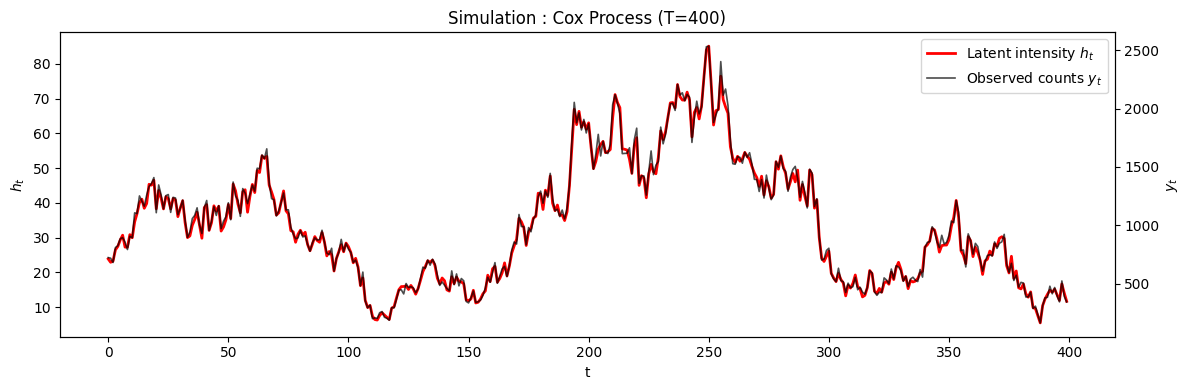

In [7]:
# pl.plot_time_series(y, h, T_show=1000, start=0, use_bars=False)
# pl.plot_histogram_h(h, nu=TRUE_PARAMS["nu"], phi=TRUE_PARAMS["phi"], c=TRUE_PARAMS["c"], burn=200)
# pl.plot_acf_h(h, lags=40, burn=200)
# pl.plot_acf_y(y, lags=40, burn=200)
pl.plot_overlay_clean(y, h, T_show=400, start=0)

## Exact filter (Creal)

In [ ]:
phi_grid = np.linspace(0.95, 0.99, 40)
ll_exact = []

f = cf.ExactFilter(y, Z_trunc=1000)

for phi in tqdm(phi_grid, desc="Exact filter over phi"):
    ll = f.log_likelihood(phi=phi, nu=2.5, c=0.2, beta=30)
    ll_exact.append(ll)

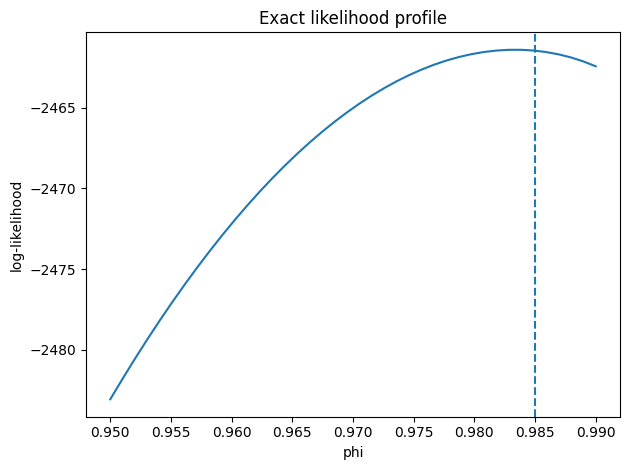

In [9]:
plt.plot(phi_grid, ll_exact)
plt.axvline(0.985, linestyle="--")
plt.xlabel("phi")
plt.ylabel("log-likelihood")
plt.title("Exact likelihood profile")
plt.tight_layout()
plt.show()

## Particle filter bootstrap

### Version implémentée 

In [4]:
particle_filter = pf.BootstrapPF(
    nu=TRUE_PARAMS["nu"],
    phi=TRUE_PARAMS["phi"],
    c=TRUE_PARAMS["c"],
    beta=TRUE_PARAMS["beta"],
    N=20000,
    seed=0,
    resample=True
)

In [7]:
ll_pf, Eh_pf = particle_filter.run(y, progress=True)

print("Bootstrap PF log-likelihood:", ll_pf)

Bootstrap PF (N=20000, seed=0): 100%|██████████| 400/400 [00:00<00:00, 430.78it/s]

Bootstrap PF log-likelihood: -2461.2070134006376


### Version librairie

In [ ]:
class CoxSSM(ssm.StateSpaceModel):
    def __init__(self, nu, phi, c, beta):
        self.nu = float(nu)
        self.phi = float(phi)
        self.c = float(c)        # c = SCALE du papier
        self.beta = float(beta)

    def PX0(self):
        # h0 ~ Gamma(nu, scale = c/(1-phi))
        # particles: Gamma(a, b) avec scale = 1/b  => b = (1-phi)/c
        b0 = (1.0 - self.phi) / self.c
        return dists.Gamma(self.nu, b0)

    def PX(self, t, h_prev):
        # z_t | h_{t-1} ~ Poisson(phi * h_{t-1} / c)
        z = np.random.poisson(self.phi * h_prev / self.c)

        # h_t | z_t ~ Gamma(nu+z_t, scale = c)
        # particles: b = 1/scale = 1/c
        b = 1.0 / self.c
        return dists.Gamma(self.nu + z, b)

    def PY(self, t, h_prev, h):
        # y_t | h_t ~ Poisson(beta * h_t)
        return dists.Poisson(self.beta * h)

In [ ]:
np.random.seed(0)

fk = ssm.Bootstrap(
    ssm=CoxSSM(TRUE_PARAMS["nu"], TRUE_PARAMS["phi"], TRUE_PARAMS["c"], TRUE_PARAMS["beta"]),
    data=y
)

alg = particles.SMC(fk=fk, N=20000)
alg.run()

ll_pf_particles = alg.logLt
print("Bootstrap PF (particles) log-likelihood:", ll_pf_particles)

Bootstrap PF (particles) log-likelihood: -2461.28578953822


## Comparaison